In [ ]:
# To run locally on Mac.

%load_ext autoreload
%autoreload 2

import os, sys
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(root)
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)
data_dir = "../data"
config_file = "../configs/config_dcn_v2_sequential.yaml"
device_string = "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/harshadakumbhare/Documents/GitHub/akshaydaf/recommender-system


In [ ]:
# # To run in colab
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd '/content/drive/MyDrive/gatech_coursework/deep_learning_final_project/GitHub_akshaydaf/recommender-system'
# data_dir = "./data"
# config_file = "./configs/config_dcn_v2_sequential.yaml"
# !pip install deepctr_torch
# !pip install torchmetrics
# device_string = "cuda"

In [83]:
# Load, clean and create train, val, test data
import pandas as pd
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples
)

def users_preprocessing(users):
    age_mapping = {
        1: 0,
        18: 1,
        25: 2,
        35: 3,
        45: 4,
        50: 5,
        56: 6
    }
    users['AgeEncoded'] = users['Age'].map(age_mapping)

    gender_mapping = {
        'F' : 0,
        'M' : 1,
    }
    users['GenderEncoded'] = users['Gender'].map(gender_mapping)

    users['Zip-codeEncoded'] = users['Zip-code'].str[:5].astype(int)
    users['Zip-codeEncoded'], unique_train_zips = pd.factorize(users['Zip-codeEncoded'])

    user_columns = ['UserID', 'AgeEncoded', 'GenderEncoded', 'Zip-codeEncoded', 'Occupation']
    return users[user_columns]


def movies_preprocessing(movies):
    movies['GenresList'] = movies['Genres'].str.split('|')
    movies_df_exploded = movies.explode('GenresList')
    one_hot = pd.get_dummies(movies_df_exploded['GenresList'], dtype=int)
    one_hot_exploded = one_hot.groupby(movies_df_exploded.index).max()
    movies = pd.concat([movies, one_hot_exploded], axis=1)

    # Preprocess years
    movies[["Title", "Year"]] = movies["Title"].str.extract(r'^(.*) \((\d{4})\)$')
    movies["Year"] = pd.to_numeric(movies["Year"], errors="coerce")

    median_year = int(movies["Year"].median(skipna=True))
    movies["Year"] = movies["Year"].fillna(median_year).astype(int)
    movies['Year'], unique_train_years = pd.factorize(movies['Year'])

    movies_columns = ['MovieID', 'Action', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'Year']
    return movies[movies_columns]

# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
# Keep all ratings for training DCN v2 model.
ratings, users, movies = clean_and_filter(ratings, users, movies, rating_threshold=4)

user_seqs   = get_user_sequences(ratings)
user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

# 3) global item set
all_movies = set(movies["MovieID"].unique())

# 4) build examples for train/val
train_exs = build_examples(user_splits, all_movies, K=5, split="train")
val_exs   = build_examples(user_splits, all_movies, K=5, split="val")
test_exs  = build_examples(user_splits, all_movies, K=5, split="test")

users = users_preprocessing(users)
movies = movies_preprocessing(movies)

In [84]:
# 5) build examples for train/val for DCN V2
# 
def build_dcnv2_input(examples, users, movies):
    df = pd.DataFrame()
    for row in examples:
        UserID = row['UserID']
        positive = row['positive']
        negative = row['negatives'][0]
        combined = pd.concat([users[users['UserID']==UserID].reset_index(drop=True), movies[movies['MovieID']==positive].reset_index(drop=True)], axis=1)
        combined['rating'] = 1
        df = pd.concat([df, combined],ignore_index=True)
        combined = pd.concat([users[users['UserID']==UserID].reset_index(drop=True), movies[movies['MovieID']==negative].reset_index(drop=True)], axis=1)
        combined['rating'] = 0
        df = pd.concat([df, combined],ignore_index=True)
    return examples

def build_dcnv2_input(examples, users, movies):
    user_ids = []
    movie_ids = []
    ratings = []

    for row in examples:
        uid = row['UserID']
        pos = row['positive']
        neg = row['negatives'][0]

        # Collect positive sample
        user_ids.append(uid)
        movie_ids.append(pos)
        ratings.append(1)

        # Collect negative sample
        user_ids.append(uid)
        movie_ids.append(neg)
        ratings.append(0)

    # Create DataFrame all at once
    df = pd.DataFrame({
        'UserID': user_ids,
        'MovieID': movie_ids,
        'Rating': ratings
    })

    # Merge user and movie features
    df = df.merge(users, on='UserID', how='left')
    df = df.merge(movies, on='MovieID', how='left')
    return df


train_df = build_dcnv2_input(train_exs, users, movies)
val_df   = build_dcnv2_input(val_exs, users, movies)
test_df   = build_dcnv2_input(test_exs, users, movies)


In [ ]:
# Read config from file or here.
from argparse import Namespace
import torch
from config import Config
import yaml

read_config_locally = False

device = torch.device(device_string)
print("Running on", device)

def dict_to_namespace(d):
    return Namespace(**{k: dict_to_namespace(v) if isinstance(v, dict) else v for k, v in d.items()})

if read_config_locally:
    config = {
        'train': {
            'batch_size': 512,
            'lr': 0.001,
            'num_epochs': 5,
            'device': device_string
        },
        'network': {
            'model': 'dcn_v2_sequential',
            'num_cross_layers': 3,
            # 'hidden_dims': [128, 64, 32],
            'hidden_dims': [64, 32],
            'dropout': 0.2
        }
    }
    config = dict_to_namespace(config)
else:
    with open(config_file, 'r') as file:
        config_dict = yaml.safe_load(file)
        config = Config(config_dict=config_dict)


Running on cpu


Trainer init device: cpu


100%|██████████| 1742/1742 [03:34<00:00,  8.14it/s]


[Epoch 1] Train Loss: 0.0009


100%|██████████| 201/201 [00:10<00:00, 19.47it/s]


{'loss': 0.0009894799184368176, 'auc': 0.8346841931343079, 'accuracy': 0.7586486339569092, 'precision': 0.7529643177986145, 'recall': 0.7698840498924255}


100%|██████████| 1742/1742 [04:26<00:00,  6.53it/s]


[Epoch 2] Train Loss: 0.0008


100%|██████████| 201/201 [00:10<00:00, 18.60it/s]


{'loss': 0.0009872573297490445, 'auc': 0.8370305299758911, 'accuracy': 0.760903537273407, 'precision': 0.7542811632156372, 'recall': 0.773925244808197}


100%|██████████| 1742/1742 [06:07<00:00,  4.74it/s]


[Epoch 3] Train Loss: 0.0007


100%|██████████| 201/201 [00:19<00:00, 10.31it/s]


{'loss': 0.001037804038583462, 'auc': 0.8361678719520569, 'accuracy': 0.7590000629425049, 'precision': 0.7575769424438477, 'recall': 0.7617624998092651}


100%|██████████| 1742/1742 [07:09<00:00,  4.05it/s]


[Epoch 4] Train Loss: 0.0006


100%|██████████| 201/201 [00:20<00:00,  9.67it/s]


{'loss': 0.0010822871940296354, 'auc': 0.8331815004348755, 'accuracy': 0.755476176738739, 'precision': 0.7544132471084595, 'recall': 0.7575650811195374}


100%|██████████| 1742/1742 [06:08<00:00,  4.73it/s]


[Epoch 5] Train Loss: 0.0006


100%|██████████| 201/201 [00:07<00:00, 27.80it/s]


{'loss': 0.0012180574398593554, 'auc': 0.8297886252403259, 'accuracy': 0.751083493232727, 'precision': 0.7557061910629272, 'recall': 0.7420444488525391}


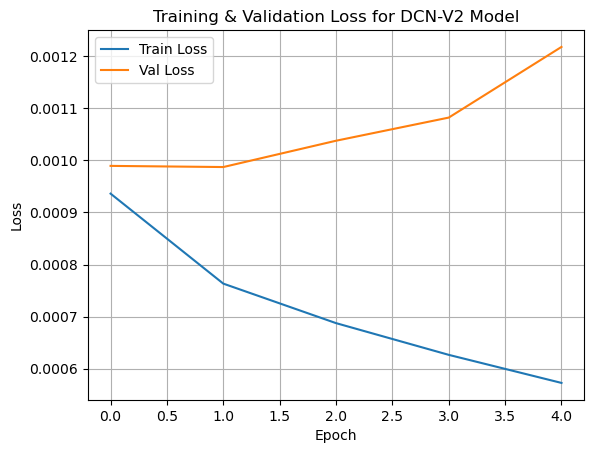

In [ ]:

from models.sequential_dcn_v2 import DCNV2_Sequential
from models.vanilla_nn import TwoLayerNet
from trainer import Trainer
from data_utils.datasets import DCNV2Dataset
from torch.utils.data import DataLoader, TensorDataset
import argparse
import pandas as pd

target_column = 'Rating'
train_df = train_df.astype(int)
val_df = val_df.astype(int)

def create_x_sparse_input(df, sparse_feature_info):
    X_sparse_input = {
        name: torch.tensor(df[name].values, device=device)
        for name, (vocab_size, embed_size) in sparse_feature_info.items()
    }
    return X_sparse_input

# Generate sparse input.
sparse_feature_info = {
    # name: (vocab_size, embed_size)
    "UserID": (6500, 64),       # uid 1 6040 users, 64-dim embedding
    "MovieID": (4000, 64),        # movie_id 1 3952 items, 64-dim embedding
    "Occupation": (21, 8),        # occupation 0 20 items, 64-dim embedding
    "AgeEncoded": (8, 4),        # age_encoded 1 7 age, 64-dim embedding
    "Zip-codeEncoded": (3500, 64),       
    "Year": (81, 8),       
}

# Generate dense input.
dense_columns = list(set(train_df.columns) - set(sparse_feature_info.keys()) - {target_column})
num_dense_features = len(dense_columns)

train_X_dense_input = torch.tensor(train_df[dense_columns].values, device=device)
train_y = torch.tensor(train_df[target_column].values, dtype=torch.float32, device=device)
train_dataset = DCNV2Dataset(create_x_sparse_input(train_df, sparse_feature_info), train_X_dense_input, train_y)
train_loader = DataLoader(train_dataset, batch_size=config.train.batch_size, shuffle=True)

val_X_dense_input = torch.tensor(val_df[dense_columns].values, device=device)
val_y = torch.tensor(val_df[target_column].values, dtype=torch.float32, device=device)
val_dataset = DCNV2Dataset(create_x_sparse_input(val_df, sparse_feature_info), val_X_dense_input, val_y)
val_loader = DataLoader(val_dataset, batch_size=config.train.batch_size, shuffle=True)


model = DCNV2_Sequential(sparse_feature_info=sparse_feature_info, num_dense_features=num_dense_features,
                         cross_layers=config.network.num_cross_layers, deep_hidden_dims=config.network.hidden_dims,
                         dropout_rate=config.network.dropout, device = device)

trainer = Trainer(model, None, config, train_loader=train_loader, lr=float(config.train.lr), val_loader=val_loader)

trainer.fit()


In [ ]:
# Evaluate Model
from evaluation import evaluate_DCNV2Model

all_movies = set(movies["MovieID"].unique())
evaluate_DCNV2Model(model=model, user_splits=user_splits, global_items=all_movies, device=device, users=users, movies=movies,
                    sparse_feature_info=sparse_feature_info) 


Feature name: UserID
Tensor shape: torch.Size([100])
Device: cpu
tensor([0, 0, 0, 0, 0])
Feature name: MovieID
Tensor shape: torch.Size([100])
Device: cpu
tensor([2225, 2651,  459,  103, 3076])
Feature name: Occupation
Tensor shape: torch.Size([100])
Device: cpu
tensor([10, 10, 10, 10, 10])
Feature name: AgeEncoded
Tensor shape: torch.Size([100])
Device: cpu
tensor([0, 0, 0, 0, 0])
Feature name: Zip-codeEncoded
Tensor shape: torch.Size([100])
Device: cpu
tensor([0, 0, 0, 0, 0])
Feature name: Year
Tensor shape: torch.Size([100])
Device: cpu
tensor([41, 76,  4,  0, 76])
torch.Size([100, 19])
[0.7357631  0.22880332 0.00886033 0.37474313 0.19806252 0.00373534
 0.3050484  0.26096797 0.11530426 0.08786086 0.31771463 0.1597677
 0.11685704 0.16672562 0.63382363 0.1862734  0.45682192 0.03359089
 0.00302638 0.45908466 0.11496966 0.80186343 0.00149845 0.34122795
 0.5293562  0.6846504  0.03746635 0.0388747  0.21442103 0.69237936
 0.15651695 0.08780502 0.06966848 0.90145177 0.03292287 0.39457852
 0

{'Hit@10': 0.5443247721623861,
 'NDCG@10': 0.2991628685530117,
 'MRR': 0.24677095003308439,
 'MAP': 0.24677095003308439}